# Training a ML force field (Energies of conformers)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymatviz.parity import density_scatter_with_hist
from rdkit import Chem
from rdkit.Chem import AllChem, PyMol
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Helpers to generate the training data

In [2]:
def gen_conformers(mol, numConfs=10_000, maxAttempts=1000, pruneRmsThresh=0.2, useExpTorsionAnglePrefs=True, useBasicKnowledge=True, enforceChirality=True):
    ids = AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, maxAttempts=maxAttempts, pruneRmsThresh=pruneRmsThresh, useExpTorsionAnglePrefs=useExpTorsionAnglePrefs, useBasicKnowledge=useBasicKnowledge, enforceChirality=enforceChirality, numThreads=0)
    return list(ids)

In [3]:
def calc_energy(mol, conformer_id, iterations=0):
	ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=conformer_id)
	ff.Initialize()
	ff.CalcEnergy()
	results = {}
	if iterations > 0:
		results["converged"] = ff.Minimize(maxIts=iterations)
	results["energy_abs"] = ff.CalcEnergy()
	return results

In [4]:
mol = Chem.AddHs(Chem.MolFromSmiles('CC(CCC)CC(C)(CCCC)O'))

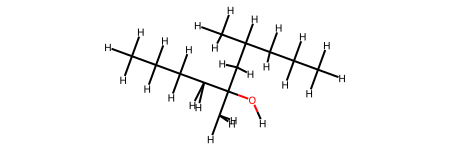

In [5]:
mol

In [6]:
conformer_ids = gen_conformers(mol)

In [9]:
v= PyMol.MolViewer()
v.DeleteAll()
for cid in conformer_ids[:50]: 
    v.ShowMol(mol,confId=cid,name='Conf-%d'%cid,showOnly=False)

In [10]:
v.server.do('set grid_mode, on')

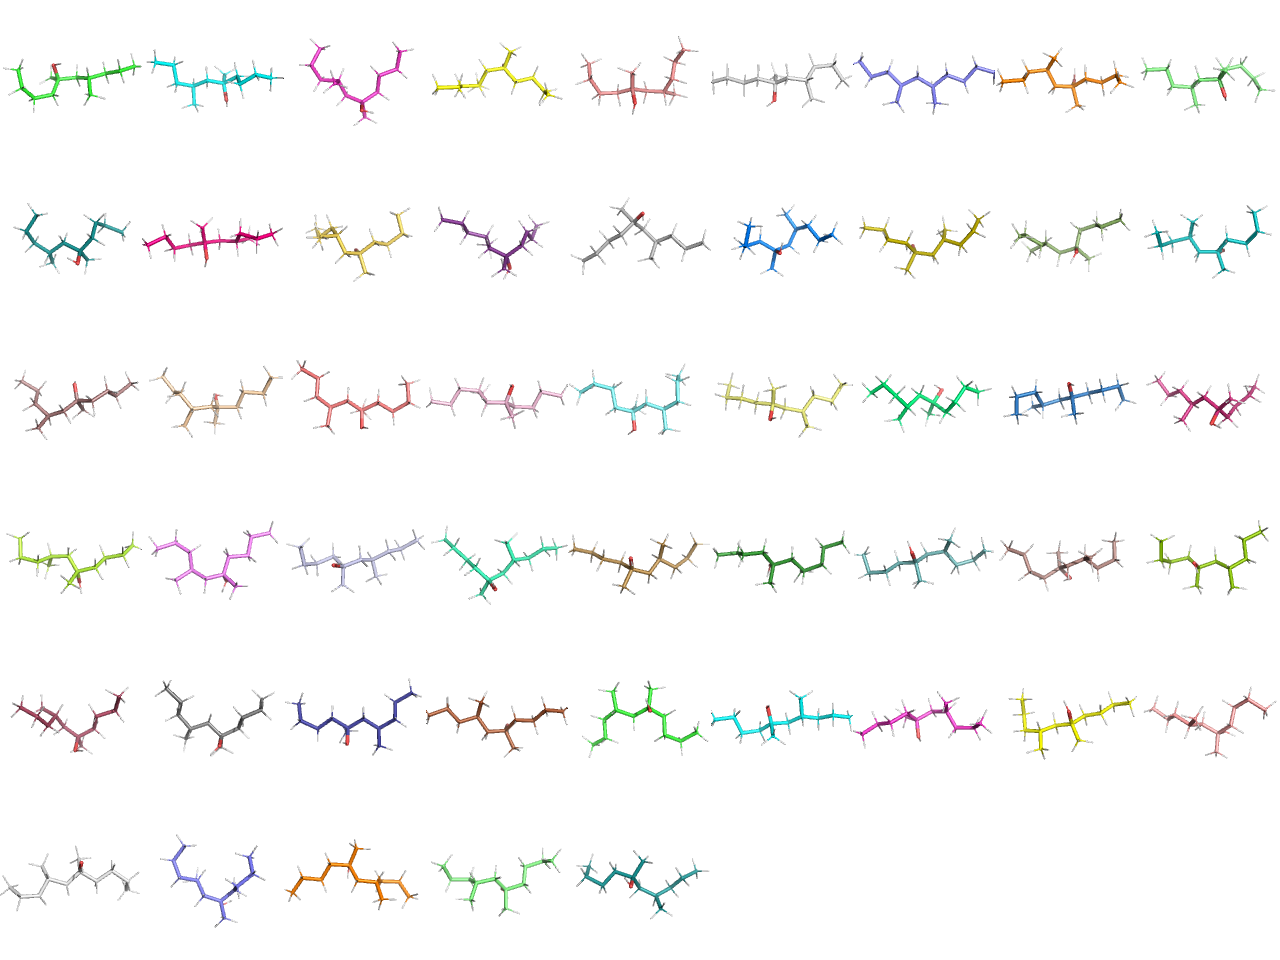

In [11]:
v.server.do('ray')
v.GetPNG()

## Generate the training data

In [12]:
coordinate_names = sum([[f'x_{n}',f'y_{n}', f'z_{n}'] for n in range(mol.GetNumAtoms())], []) # helper to define the column names

In [13]:
data = []
for conformer_id in conformer_ids:
    energy = calc_energy(mol, conformer_id)['energy_abs']
    positions = mol.GetConformer(conformer_id).GetPositions().flatten()
    position_dict = dict(zip(coordinate_names, positions))
    position_dict['energy'] = energy
                         
    data.append(position_dict)

In [14]:
data = pd.DataFrame(data).sample(len(data))

In [15]:
data

,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,x_36,y_36,z_36,x_37,y_37,z_37,x_38,y_38,z_38,energy
2890,2.329699,-0.799580,1.975326,1.729676,-1.143319,0.600026,2.527137,-0.361507,-0.389982,2.492361,...,-4.815999,2.734475,0.387260,-3.593539,2.469324,1.752375,-0.496985,-0.660937,-2.508775,43.886066
95,-2.067469,-1.714830,0.479505,-1.660660,-0.333674,0.040107,-2.625883,0.748458,0.465180,-3.987405,...,5.967745,0.801791,-0.155783,4.818059,0.219971,-1.373836,1.311366,-2.741345,0.310035,45.118930
768,2.711889,-1.898063,0.382692,1.789353,-0.785179,0.830708,2.390883,0.541313,0.987067,3.031380,...,-5.648987,-0.545280,-1.153441,-4.378845,-0.951117,0.073270,-0.250593,1.667492,-0.952905,61.224693
2918,-2.869466,-0.525203,-1.207330,-1.813249,-0.450084,-0.088800,-1.703400,0.894793,0.455985,-2.946613,...,4.864878,1.887753,-0.335292,3.056113,1.956007,-0.697302,1.150847,-2.773437,1.260931,81.839788
2732,-1.058966,-1.673032,-1.352377,-1.374138,-0.326545,-0.802940,-2.657802,-0.329483,0.001896,-3.021658,...,5.304845,0.021215,-1.585736,4.568128,1.575814,-2.045590,0.868023,2.100672,0.899543,59.061369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2.039776,-0.870959,0.923630,1.678854,0.206926,-0.048884,2.590940,0.315404,-1.248461,4.001955,...,-5.361184,0.771299,-0.731747,-3.591414,1.086171,-0.983810,-1.327469,-1.372868,1.850101,70.279980
312,-1.706802,-0.924264,-2.258109,-1.922160,-0.614556,-0.757754,-2.919016,0.498782,-0.784798,-3.406618,...,4.908083,1.672235,0.185230,4.356473,2.516025,1.703405,-0.631976,-2.137684,1.395773,61.476984
1917,2.726611,-1.643117,-0.485888,1.645096,-0.601452,-0.151681,2.155053,0.527005,0.639261,3.234505,...,-4.847552,2.466620,-0.564456,-5.680949,1.199792,-1.497399,-1.372408,-2.677700,0.786135,58.642627
2124,-2.964143,-1.638501,0.461038,-1.728344,-0.674898,0.603745,-1.939238,0.494239,-0.284338,-3.284811,...,5.110663,0.854611,0.372006,4.637914,2.644513,0.310606,0.369902,-0.124758,2.099240,65.610063


(array([ 119.,  809., 1171.,  706.,  276.,  115.,   21.,    7.,    4.,
           3.]),
 array([ 36.77543582,  45.73287919,  54.69032255,  63.64776592,
         72.60520929,  81.56265265,  90.52009602,  99.47753939,
        108.43498276, 117.39242612, 126.34986949]),
 <BarContainer object of 10 artists>)

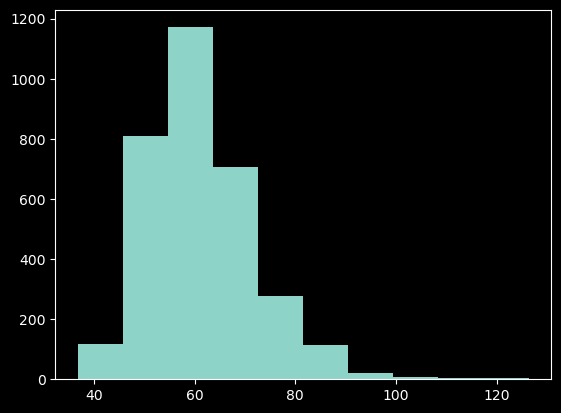

In [16]:
plt.hist(data['energy'])

## Build a model

In [17]:
positions = data[coordinate_names] # X
energies = data['energy'] # y

In [18]:
len(positions)

3231

In [33]:
train_points = 3000
train_positions = positions[:train_points]
test_positions = positions[train_points:]
train_energies = energies[:train_points]
test_energies = energies[train_points:]

In [34]:
from sklearn.ensemble import HistGradientBoostingRegressor


model = HistGradientBoostingRegressor()
model.fit(train_positions, train_energies)

HistGradientBoostingRegressor()

## Test the model

In [40]:
train_predictions = model.predict(train_positions)

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

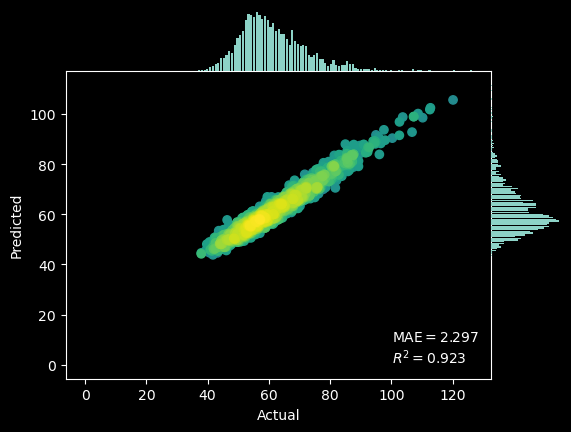

In [41]:
density_scatter_with_hist(train_energies.values, train_predictions)

In [42]:
positions.shape

(3231, 117)

In [38]:
test_predictions = model.predict(test_positions)

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

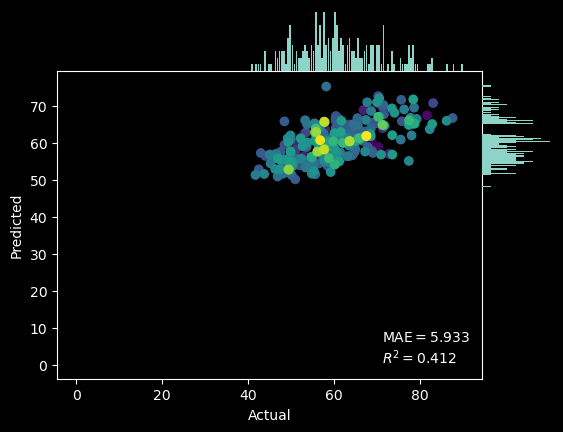

In [39]:
density_scatter_with_hist(test_energies.values, test_predictions)

## Change the positions

In [43]:
translated_positions = train_positions + 1
translated_predictions = model.predict(translated_positions)

<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

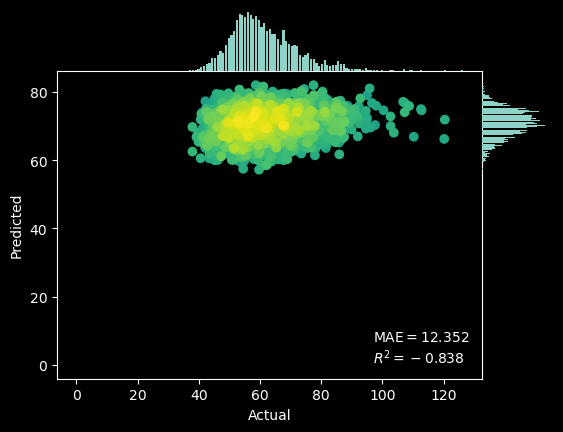

In [44]:
density_scatter_with_hist(train_energies.values, translated_predictions)